In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda, Layer, Concatenate, Reshape
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

Using TensorFlow backend.


In [2]:
batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 10
epsilon_std = 1.0

In [3]:
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
#decoder_mean = Dense(original_dim, activation='sigmoid') # orig keras, BerGauss
#decoder_mean = Dense(original_dim, activation='relu') # My BerGauss 
h_decoded = decoder_h(z)
#x_decoded_mean = decoder_mean(h_decoded)

mu = Dense(original_dim, activation='linear')(h_decoded)
re_mu = Reshape((784,1))(mu)
log_var = Dense(original_dim, activation='linear')(h_decoded)
re_log_var = Reshape((784,1))(log_var)
mu_log_var = Concatenate()([re_mu, re_log_var])

In [4]:
# Custom loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    #def vae_loss(self, x, x_decoded_mean):
        #xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
    def vae_loss(self, x, mu_log_var) :
        x = x[:,:,np.newaxis]
        N = K.int_shape(mu_log_var)[1]
        mu = mu_log_var[:,:,0]
        log_var = mu_log_var[:,:,1]
        mu = mu[:,:,np.newaxis]
        log_var = log_var[:,:,np.newaxis]
        recon = K.sum(-0.5*K.exp(-1.*log_var)*K.square(x - mu), axis=1)
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        #return K.mean(xent_loss + kl_loss)
        return K.mean(recon + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x

#y = CustomVariationalLayer()([x, x_decoded_mean])
y = CustomVariationalLayer()([x, mu_log_var])
vae = Model(x, y)

vae.compile(optimizer='adagrad', loss=None)

/data1/groups/NextGenWeather_shared/sw/python/python2.7/gcc7.1.1/lib/python2.7/site-packages/ipykernel_launcher.py:33: UserWarning: Output "custom_variational_layer_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_1" during training.


In [5]:
# train the VAE on MNIST digits
NORMALIZE = True
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train > 0.5
x_test = x_test > 0.5
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

if NORMALIZE :
    train_std = np.std(x_train, axis=0)
    train_std[train_std == 0] = 1
    train_mu = np.mean(x_train, axis=0)
    x_train = (x_train - train_mu)/train_std
    x_test = (x_test - train_mu)/train_std

In [14]:
x_train.shape

(60000, 784)

In [6]:
"""
vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
validation_data=(x_test, None))
"""
vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size)

Epoch 1/10
60000/60000 [==============================] - 10s - loss: nan    
Epoch 2/10
60000/60000 [==============================] - 10s - loss: nan    
Epoch 3/10
60000/60000 [==============================] - 10s - loss: nan    
Epoch 4/10
60000/60000 [==============================] - 10s - loss: nan    
Epoch 5/10
60000/60000 [==============================] - 10s - loss: nan    
Epoch 6/10
60000/60000 [==============================] - 9s - loss: nan     
Epoch 7/10
60000/60000 [==============================] - 10s - loss: nan    
Epoch 8/10
60000/60000 [==============================] - 10s - loss: nan    
Epoch 9/10
60000/60000 [==============================] - 10s - loss: nan    
Epoch 10/10
60000/60000 [==============================] - 10s - loss: nan    


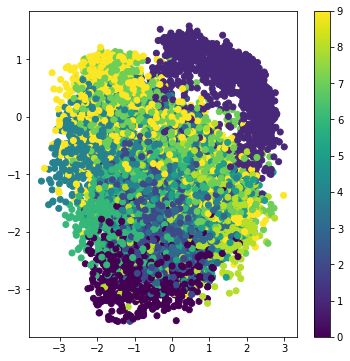

In [9]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()